**Authors:** DeFeng Zhou

**Date:** 2023-12-04

# Data Analysis

Let`s start analyzing our data using the Pandas library.

In [1]:
import pandas as pd

### Train data CSV Reading:

In [2]:
train_df = pd.read_csv("/home/jack/Project/zdf/ComputerVision/plant_kaggle/plant_dataset/train/train_label.csv")
train_df

images              labels
0     a8ab965f868fc44c.jpg             healthy
1     a5d8924f7fad18a0.jpg             healthy
2     fab3f2b1c0d2a982.jpg                scab
3     d9b283cd98b19d13.jpg                scab
4     852979c129dde25d.jpg  frog_eye_leaf_spot
...                    ...                 ...
2995  eb8100abfd56157c.jpg             healthy
2996  a89097fa5afb011b.jpg             healthy
2997  f05ad49e5f0a0d4b.jpg  frog_eye_leaf_spot
2998  be7ef6d45ac18401.jpg             complex
2999  c5b420ff00b9fc2d.jpg                scab

[3000 rows x 2 columns]

### Null and Missing values check:

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  3000 non-null   object
 1   labels  3000 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


There are no label missing values in the dataset.

### Unique Label values (number of catagories):

In [4]:
train_df['labels'].value_counts()

labels
scab                               767
healthy                            753
frog_eye_leaf_spot                 523
rust                               309
complex                            256
powdery_mildew                     182
scab frog_eye_leaf_spot             90
scab frog_eye_leaf_spot complex     40
frog_eye_leaf_spot complex          27
rust frog_eye_leaf_spot             21
rust complex                        17
powdery_mildew complex              15
Name: count, dtype: int64

### Data histogram and Distribution

In [5]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

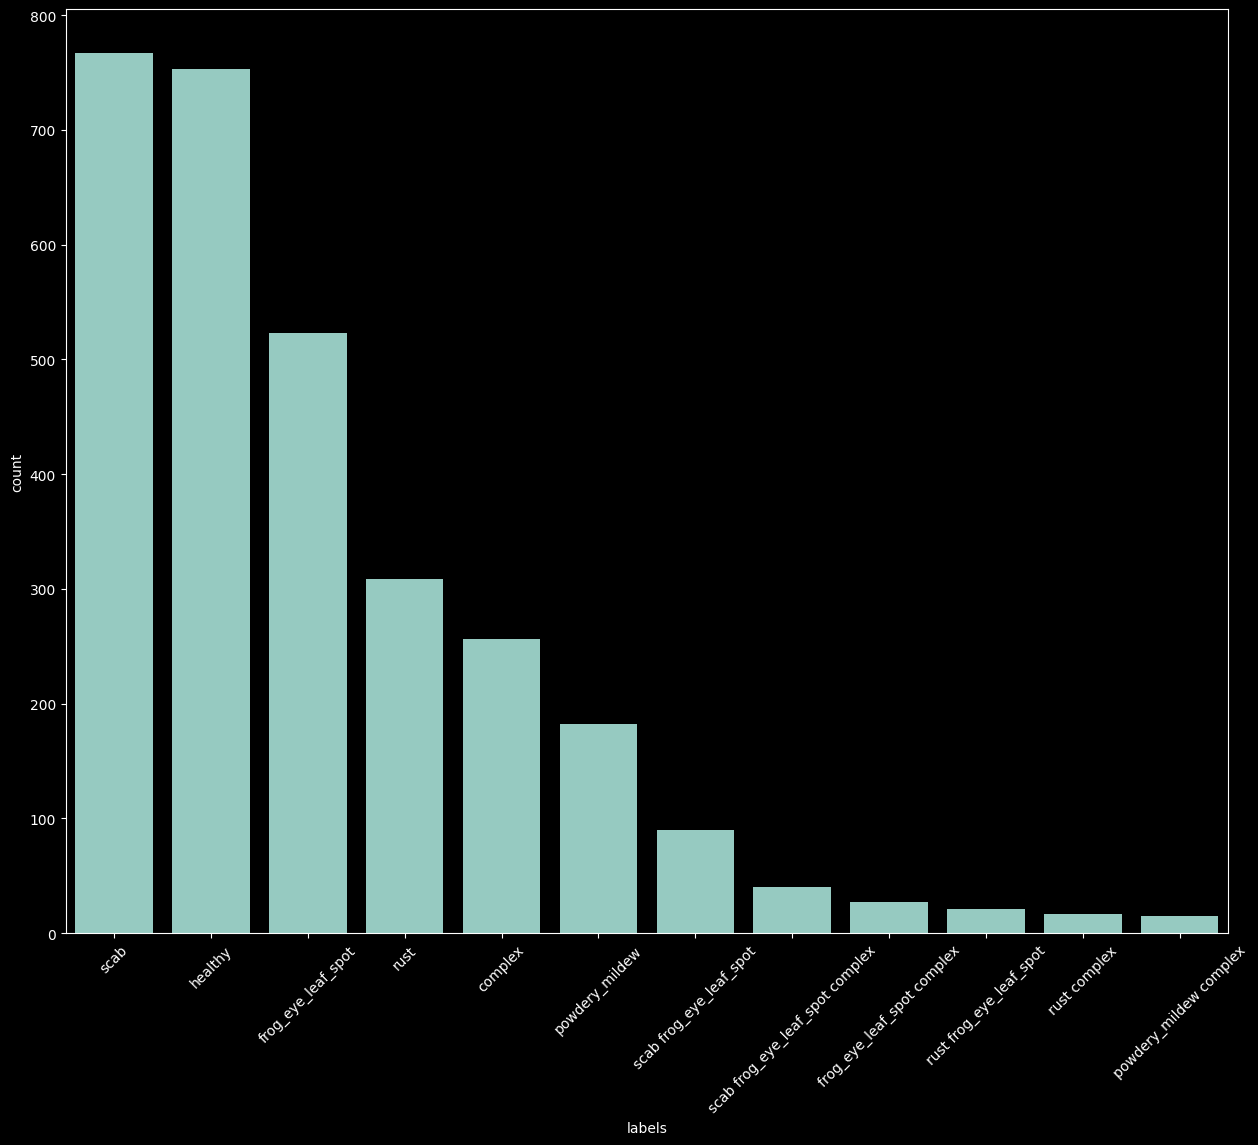

In [6]:
plt.figure(figsize=(15,12))
labels_hist = sns.barplot(x=train_df.labels.value_counts().index, y=train_df.labels.value_counts())
for item in labels_hist.get_xticklabels():
    item.set_rotation(45)

In [7]:
fig = go.Figure(data=[go.Pie(labels=train_df['labels'].value_counts().index,values=train_df['labels'].value_counts().values)])
fig.update_layout(title='Label distribution')
fig.show()


### Plant Categories Visualisation

In [8]:
train_image_path = "/home/jack/Project/zdf/ComputerVision/plant_kaggle/plant_dataset/train/images"

Image Display Method

In [114]:
def display_images(train_path,labels,rows,cols):
  fig = plt.figure(figsize=(20, 10))
  idx = 1

  for i in range(rows):
    df = list(train_df.loc[train_df['labels'] == labels[i]]['images'])
    for j in range(cols):
      img_path = df[j]
      img = cv2.imread(os.path.join(train_path,img_path))
      image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      plt.subplot(rows,cols,idx)
      plt.imshow(image)
      plt.title("Class:" + str(labels[i]) + ",Image:"+ str(j+1))
      idx += 1


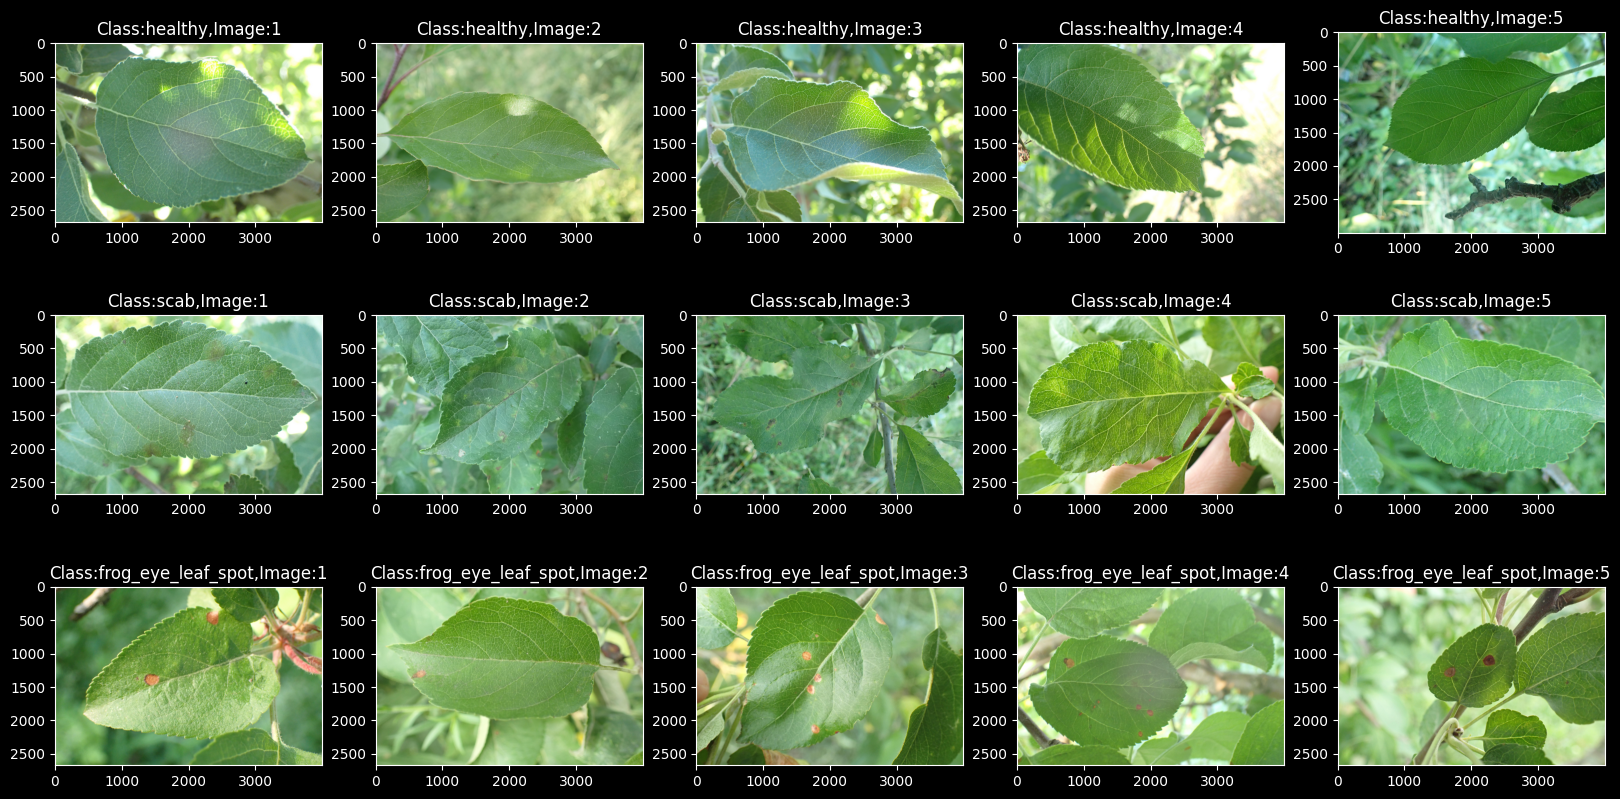

In [115]:
labels_arr = train_df['labels'].unique()
display_images(train_image_path,labels_arr,3,5)

## Conclusions from the Data Analysis
We can see that some of the leaves may have couple of diseases. It means that the models output will be a vector that contains 1s and 0s , depending on the leaf diseases respectively. Therefore , we will need to encode the data frame in accordance.  

# Data Pre-Processing

### Imports and Installations

In [11]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

/home/jack/anaconda3/envs/plant_torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [12]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
#import torch_optimizer as optimizer
import torch.optim as optim

### Change the labels
In the origin dataset We have 12 label catagories.

But there are duplications between different categories, e.g. [scab] exists in
multiple categories, which affects the training accuracy of the model.

So in the later We will process 6 label catagories and encode them with one-hot encoding.

In [13]:
def change_label(file_path, new_file_path):
  
  data_df = pd.read_csv(file_path)

  # change the label
  data_df['labels'] = data_df['labels'].replace({"scab frog_eye_leaf_spot": "scab",
                                                    "scab frog_eye_leaf_spot complex": "scab",
                                                    "rust frog_eye_leaf_spot": "rust",
                                                    "rust complex": "rust",
                                                    "frog_eye_leaf_spot complex": "frog_eye_leaf_spot",
                                                    "powdery_mildew complex": "powdery_mildew"})

  # save as the new csv file
  #new_csv_path = "/home/jack/Project/zdf/ComputerVision/plant_kaggle/plant_dataset/train/modified_train_label.csv"
  data_df.to_csv(new_file_path, index=False)

### Folder path setting

In [14]:
dir = "/home/jack/Project/zdf/ComputerVision/plant_kaggle/plant_dataset"
train_csv_path = dir + "/train/train_label.csv"
new_train_csv_path = dir + "/train/modified_train_label.csv"

test_csv_path = dir + "/test/test_label.csv"
new_test_csv_path = dir + "/test/modified_test_label.csv"

val_csv_path = dir + "/val/val_label.csv"
new_val_csv_path = dir + "/val/modified_val_label.csv"

change_label(train_csv_path, new_train_csv_path)
change_label(test_csv_path, new_test_csv_path)
change_label(val_csv_path, new_val_csv_path)

train_df = pd.read_csv(new_train_csv_path)
val_df = pd.read_csv(new_val_csv_path)
test_df = pd.read_csv(new_test_csv_path)

train_folder_path = dir + "/train/images"
train_path = os.listdir(train_folder_path)

val_folder_path = dir + "/val/images"
val_path = os.listdir(val_folder_path)

test_folder_path = dir + "/test/images"
test_path = os.listdir(test_folder_path)

### Data Frame Encoding


In [15]:
train_df_cp = train_df.copy()
val_df_cp = val_df.copy()
test_df_cp = test_df.copy()

In [16]:
train_df_cp['label_list'] = train_df_cp['labels'].str.split(' ')
val_df_cp['label_list'] = val_df_cp['labels'].str.split(' ')
test_df_cp['label_list'] = test_df_cp['labels'].str.split(' ')

In [17]:
def lbl_lgc(col,lbl_list):
    if col in lbl_list:
        res = 1 
    else:
        res = 0
    return res

In [18]:
lbls = ['healthy','complex','rust','frog_eye_leaf_spot','powdery_mildew','scab']
for x in lbls:
    train_df_cp[x]=0
    val_df_cp[x]= 0 
    test_df_cp[x] = 0


for x in lbls:
    train_df_cp[x] = np.vectorize(lbl_lgc)(x,train_df_cp['label_list'])
    val_df_cp[x] = np.vectorize(lbl_lgc)(x,val_df_cp['label_list'])
    test_df_cp[x] = np.vectorize(lbl_lgc)(x,test_df_cp['label_list'])

In [19]:
train_df_cp.head()

images              labels            label_list  healthy  \
0  a8ab965f868fc44c.jpg             healthy             [healthy]        1   
1  a5d8924f7fad18a0.jpg             healthy             [healthy]        1   
2  fab3f2b1c0d2a982.jpg                scab                [scab]        0   
3  d9b283cd98b19d13.jpg                scab                [scab]        0   
4  852979c129dde25d.jpg  frog_eye_leaf_spot  [frog_eye_leaf_spot]        0   

   complex  rust  frog_eye_leaf_spot  powdery_mildew  scab  
0        0     0                   0               0     0  
1        0     0                   0               0     0  
2        0     0                   0               0     1  
3        0     0                   0               0     1  
4        0     0                   1               0     0

### The Plant Dataset Class

In [20]:
class Plant_Dataset(Dataset):
  def __init__(self,folder_path,data_paths,data_df,size=224,transforms=None, train=True):
    self.folder_path = folder_path
    self.data_paths = data_paths
    self.data_df = data_df
    self.transforms = transforms
    self.train = train
    self.size = size

  def __getitem__(self, idx):
    img_path = os.path.join(self.folder_path,self.data_paths[idx])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (self.size, self.size), interpolation=cv2.INTER_AREA)
    image = np.asarray(image)

    #if self.train: #for train or validation data
     #label = self.data_df.loc[self.data_df['image']==self.data_paths[idx]].values[0][1]
    j = 0
    vector = [0]*6
    values = self.data_df.loc[self.data_df['images']==self.data_paths[idx]].values
    for i in range(3,9):
      num = values[0][i]
      vector[j] = num
      j = j+1
    
    vector=np.asarray(vector)
      
    
    # if self.transforms:
    #   image = self.transforms(image=image)['image']
    if self.transforms:
        # Check if the image is a numpy array, if not convert it
        if not isinstance(image, np.ndarray):
            image = image.numpy()

        # transformed_data = self.transforms(image=image)
        # # Use the correct key based on the transformation output
        # image = transformed_data.get('image', transformed_data.get('images'))
        image = self.transforms(image=image)['image']

    if self.train:
     return image,vector #train or validation data
    else:
      return image,vector, self.data_paths[idx] #test data


  def __len__(self):
    return len(self.data_paths) 

### Focal Loss Class

In [21]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.2, gamma=2, logist=False, reduce='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha # the scalar factor between 0 and 1 
        self.gamma = gamma # focusing parameter(always positive) that reduces the relative loss for well-classified examples and puts more focus on hard misclassified examples
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        #self.logist = logist # log probabilities 
        self.reduce = reduce # Specifies the reduction to apply to the output - none/mean/sum. ‘none’: no reduction will be applied, ‘mean’: the sum of the output will be divided by the number of elements in the output, ‘sum’: the output will be summed.

    def forward(self, inputs, targets):
        BCE_loss = self.cross_entropy_loss(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

## Train and Validation Methods

In [22]:
from tqdm.auto import tqdm

### Train Validation General Method

In [23]:
def train_val(model,loader_train,loader_val,opt,criterion,epoch):
  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []
  for e in range(epoch):
    loss_t, acc_t = train(e,model,loader_train,opt,criterion)
    train_loss.append(loss_t)
    train_acc.append(acc_t)
    loss_v , acc_v = validation(e, model, loader_val)
    val_loss.append(loss_v)
    val_acc.append(acc_v)
     
    gc.collect()
    
    torch.cuda.empty_cache()

  return model,train_loss,train_acc,val_loss,val_acc

### Train Method

In [24]:
def train(e,model,loader,opt,criterion):
  model.train()
  treshold = 0.5
  acc_loss = 0 
  correct = 0
  target_sum = 0
 # tqdm_loader = tqdm(loader)
  for i, (img, target) in enumerate(loader):
    
    img = img.float()
   # img = img.permute(0,3,1,2).float()
    target = target.float()
    img = img.cuda()
    target = target.cuda()
    
    opt.zero_grad()
    output = torch.sigmoid(model(img)).float()
    loss = criterion(output, target)
    loss.backward()
    opt.step()
    
    acc_loss += loss.item()
    avg_loss = acc_loss/(i+1)
    
    output = torch.where(output > treshold, 1,0)
    
    #correct += output.eq(target.view_as(output)).sum().item()/(6*len(target))
    
    res = output==target
    
    for tensor in res:
        if False in tensor:
            continue
        else:
            correct += 1
    
    target_sum += len(target)
    avg_acc = correct/((target_sum))
    
    #tqdm_loader.set_description("Epoch {}, train_loss={:4} , acc={:4}".format(e,round(avg_loss,4), round(avg_acc ,4)))
    
    del img
    del target
    del output
    del loss
    del res
    
    gc.collect() 
    torch.cuda.empty_cache()
  print("Epoch {}, train_loss={:4} , acc={:4}".format(e,round(avg_loss,4), round(avg_acc ,4)))
  del acc_loss
  
  del target_sum
  del correct

    
  return avg_loss, avg_acc




### Validation Method

In [25]:
def validation(e, model, loader):
  model.eval()
  #tqdm_loader = tqdm(loader_val)
  treshold = 0.5
  acc_loss = 0
  correct =0
  target_sum=0
  for i, (img,target) in enumerate(loader):
    img = img.float()
 #   img = img.permute(0,3,1,2).float()
    target = target.float()

    img = img.cuda()
    target = target.cuda()

    with torch.no_grad():
      output = torch.sigmoid(model(img)).float()
      loss = criterion(output, target)
        
    acc_loss += loss.item()
    avg_loss = acc_loss/(i+1)
    
    output = torch.where(output > treshold, 1,0)
    
   # correct += output.eq(target.view_as(output)).sum().item()/(6*len(target))
    res = output==target
    
    for tensor in res:
        if False in tensor:
            continue
        else:
            correct += 1
    
    
    target_sum += len(target)
    avg_acc = correct/((target_sum))
    
    
   # tqdm_loader.set_description("Epoch {}, val_loss={:4} , val_acc={:4}".format(e,round(avg_loss,4), round(avg_acc ,4)))
    
    del img
    del target
    del output
    del res
    
    
    gc.collect() 
    torch.cuda.empty_cache()
  print("Epoch {}, val_loss={:4} , acc={:4}".format(e,round(avg_loss,4), round(avg_acc ,4)))

  del target_sum
  del acc_loss
  del correct

    
  return avg_loss, avg_acc


### Test Mehtod

In [26]:
def model_test(model,test_loader):
 model.eval()
 images = []
 predictions = []   
 treshold = 0.5
 correct =0
 target_sum=0
 for i ,(img, target, img_name) in enumerate(test_loader):
    images.append(img_name)
    img = img.float()
    img = img.cuda()
    target = target.float()
    target = target.cuda()
    with torch.no_grad():
      output = torch.sigmoid(model(img)).float()
    
    output = torch.where(output > treshold, 1,0)
    predictions.append(output)
    #pdb.set_trace
    res = output==target
    
    for tensor in res:
        if False in tensor:
            continue
        else:
            correct += 1
    
    
    target_sum += len(target)
    avg_acc = correct/((target_sum))
    del img
    del output
    
    gc.collect() 
    torch.cuda.empty_cache()
    
    
 return images, predictions, avg_acc

### Submission method

In [27]:
def submission(images,predictions):
  str_preds = []
  img_names = []
  j=0  
  for vec in predictions:
    labels = []
    for i in range(len(vec[0])):
      if vec[0][i]==1:
       labels.append(lbls[i])
         
    l = ' '.join(labels)
    str_preds.append(l) 
    img_names.append(images[j][0])
    j += 1
    
  output = pd.DataFrame({'image': img_names, 'labels': str_preds})
  output.to_csv('submission.csv',index=False)             
            
    

### Model Save method

In [95]:
def save_model(model,optimizer,epoch,train_loss,val_loss,train_acc,val_acc,path):
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc
            }, path)

### Model Load method

In [96]:
def load_model(path,model,optimizer):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  train_loss = checkpoint['train_loss']
  val_loss = checkpoint['val_loss']
  train_acc = checkpoint['train_acc']
  val_acc = checkpoint['val_acc']
  return train_loss,val_loss,train_acc,val_acc,epoch

### Plot Graphs Method

In [30]:
def plot_graphs(train_loss,val_loss,train_acc,val_acc,epcohs, fig_path):
  plt.figure(figsize=(30,10))

  plt.subplot(1,2,1)
  plt.title("Loss")
  plt.plot(list(range(0,epcohs)),train_loss, label='Train')
  plt.plot(list(range(0,epcohs)), val_loss, label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Rate')
  plt.legend()
    
  plt.subplot(1,2,2)
  plt.title("Accuracy")
  plt.plot(list(range(0,epcohs)),train_acc, label='Train')
  plt.plot(list(range(0,epcohs)), val_acc, label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Rate')
  plt.legend()
  plt.savefig(fig_path)
  

# Models and Tests

**The first model will be relatively simple.**

The models development and complexity will be gradual and I will use more complex tools from submission to submission. 

### Imports

In [31]:
import torchvision.models as models
#!pip install albumentations==0.4.6
#!pip install -U git+https://github.com/albu/albumentations > /dev/null
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms as T
import gc 

In [32]:
gc.collect() 
torch.cuda.empty_cache()

# 1st Model



*   **Architecture**: Resnext50 (Not Pre-Trained)
*   **Transforms**: Normalize
*   **Batch Size**: 25
*   **Epochs** : 20
*   **Learning Rate**: 0.0001
*   **Learning Rate Scheduler**: None










In [33]:
BS = 25
EPOCHS = 20
train_num = 0
transforms = A.Compose([A.Normalize(),ToTensorV2()])

### Train and Validation Data Loading using Dataloader

In [34]:
train_data = Plant_Dataset(train_folder_path, train_path,train_df_cp, transforms=transforms,train=True)
loader_train = DataLoader(train_data, batch_size=BS, shuffle=True,num_workers=4)
val_data = Plant_Dataset(val_folder_path,val_path, val_df_cp, transforms=transforms,train=True) 
loader_val = DataLoader(val_data,batch_size=BS, shuffle=False,num_workers=4)

In [35]:
model = models.resnext50_32x4d(pretrained=False)

in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features,6)

/home/jack/anaconda3/envs/plant_torch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.

/home/jack/anaconda3/envs/plant_torch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.



In [36]:
model.cuda()
criterion = torch.nn.BCELoss()
criterion.cuda()
optimi = optim.Adam(model.parameters(), lr=1e-4)

### Model Training and Validation

In [37]:
model,train_loss,train_acc,val_loss,val_acc = train_val(model,loader_train,loader_val,optimi,criterion,EPOCHS)
model_path = f"/home/jack/Project/zdf/ComputerVision/plant_kaggle/Torch/pretrained/resnext50_32x4d_train_num{train_num}.pth"
save_model(model,optimi,EPOCHS,train_loss,val_loss,train_acc,val_acc, model_path)

Epoch 0, train_loss=0.4197 , acc=0.0493
Epoch 0, val_loss=0.4013 , acc=0.0533
Epoch 1, train_loss=0.3752 , acc=0.1313
Epoch 1, val_loss=0.3697 , acc=0.18
Epoch 2, train_loss=0.3668 , acc=0.1703
Epoch 2, val_loss=0.3798 , acc=0.205
Epoch 3, train_loss=0.3535 , acc=0.2117
Epoch 3, val_loss=0.402 , acc=0.1867
Epoch 4, train_loss=0.34 , acc=0.2657
Epoch 4, val_loss=0.3705 , acc=0.245
Epoch 5, train_loss=0.3365 , acc=0.2813
Epoch 5, val_loss=0.3776 , acc=0.2833
Epoch 6, train_loss=0.323 , acc=0.3243
Epoch 6, val_loss=0.3794 , acc= 0.3
Epoch 7, train_loss=0.3191 , acc=0.352
Epoch 7, val_loss=0.3407 , acc=0.325
Epoch 8, train_loss=0.3032 , acc=0.374
Epoch 8, val_loss=0.3291 , acc=0.3767
Epoch 9, train_loss=0.2891 , acc=0.436
Epoch 9, val_loss=0.3577 , acc=0.39
Epoch 10, train_loss=0.2776 , acc=0.4493
Epoch 10, val_loss=0.3381 , acc=0.4017
Epoch 11, train_loss=0.2544 , acc=0.5143
Epoch 11, val_loss=0.4353 , acc=0.3967
Epoch 12, train_loss=0.2576 , acc=0.5167
Epoch 12, val_loss=0.352 , acc=0.39

### Train/Validation Loss and Accuracy Graphs

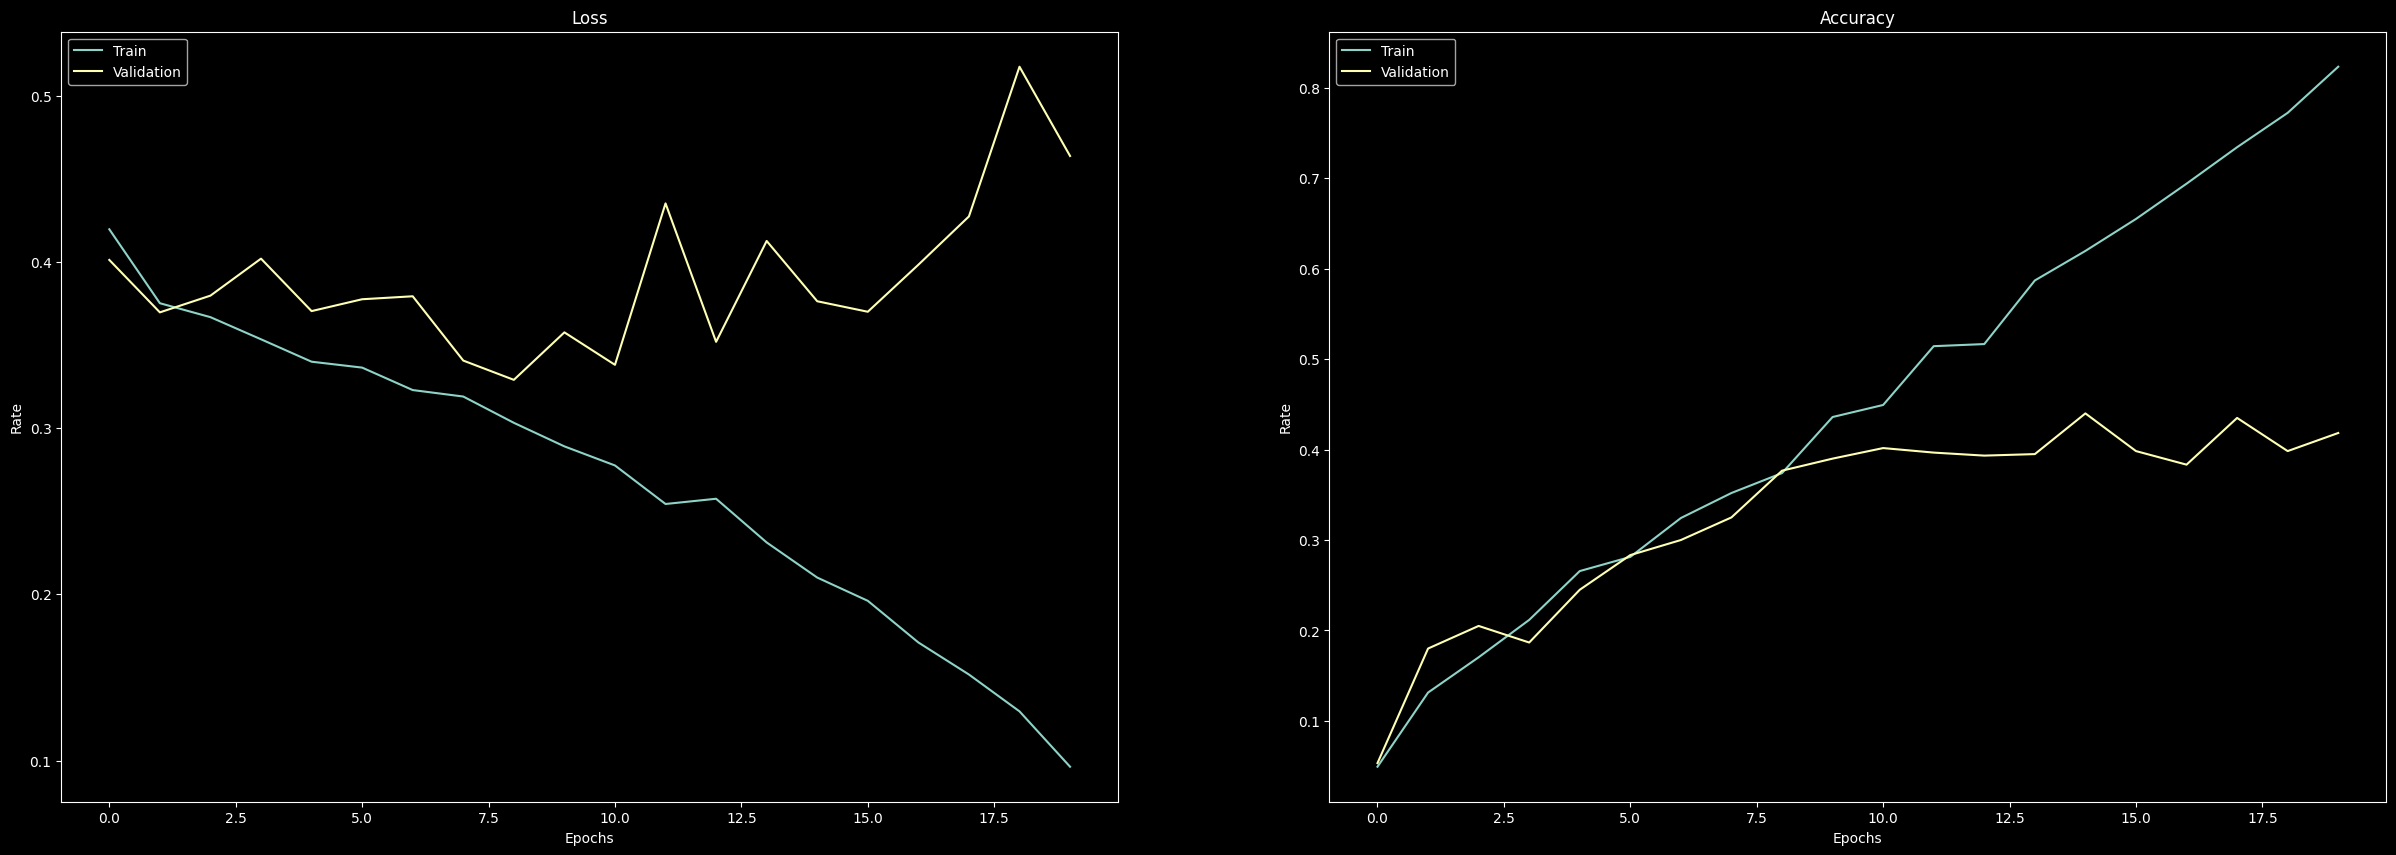

In [38]:
fig_path=f"/home/jack/Project/zdf/ComputerVision/plant_kaggle/Torch/resnext50_32x4d_num{train_num}_result.png"
plot_graphs(train_loss,val_loss,train_acc,val_acc,EPOCHS, fig_path)

## Model Test and Submission

In [39]:
gc.collect() 
torch.cuda.empty_cache()

In [40]:
test_data = Plant_Dataset(test_folder_path,test_path,test_df_cp, transforms=transforms,train=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False,num_workers=0)

In [41]:
images,predictions, acc = model_test(model,test_loader)
csv_path = "/home/jack/Project/zdf/ComputerVision/plant_kaggle/Torch/resnext_Train0_submission.csv"
submission(images,predictions,csv_path)
print("Model resnext50 Train0 Test Acc:" ,acc)

Model resnext50 Train0 Test Acc: 0.37166666666666665


## 1st Model acc : **0.37166666666666665**

# 2nd Model

In this model we will use couple of **augmentations** to improve the results and reduce the overfitting we had in the 1st model. We will also increase the batch size to 50 and the number of epochs to 30.  
We will use some augmentations that we learned in the course and more:  

 
*   Rotate
*   Blur
*   HorizontalFlip
*   VerticalFlip
*   GaussNoise
*   IAASharpen
*   MotionBlur
*   RandomBrightnessContrast



It is importnat to choose specific augmentations that won't not cause damage and destroy the data. For example, we chose not using augmentations that relate to RGB colors and channels changing. 




In [42]:
from albumentations import (
    Rotate, Blur, HorizontalFlip, VerticalFlip, GaussNoise, IAASharpen, MotionBlur,RandomBrightnessContrast 
)

In [43]:
display_transforms = A.Compose([Rotate(always_apply=True), Blur(always_apply=True), HorizontalFlip(always_apply=True), VerticalFlip(always_apply=True),
                                GaussNoise(always_apply=True), IAASharpen(always_apply=True), MotionBlur(always_apply=True),
                                RandomBrightnessContrast(always_apply=True)])

/home/jack/anaconda3/envs/plant_torch/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning:

IAASharpen is deprecated. Please use Sharpen instead



### Overview



*   **Architecture**: Resnext50 (Not Pre-Trained)  
*   **Optimizer**: Adam
*   **Transforms**: Blur, HorizontalFlip, VerticalFlip, GaussNoise, IAASharpen, RandomBrightnessContrast, Normalize
*   **Batch Size**: 50
*   **Epochs** : 30
*   **Learning Rate**: 0.0001
*   **Learning Rate Scheduler**: None










## Model and Test settings

In [44]:
BS = 50
EPOCHS = 30
transforms = A.Compose([Blur(), HorizontalFlip(), VerticalFlip(), GaussNoise(),
                        IAASharpen(),RandomBrightnessContrast(),
                        A.Normalize(),ToTensorV2()])
val_transforms = A.Compose([A.Normalize(),ToTensorV2()])
train_num = 1

In [45]:
train_data = Plant_Dataset(train_folder_path,train_path,train_df_cp, transforms=transforms,train=True)
loader_train = DataLoader(train_data, batch_size=BS, shuffle=True,num_workers=4)
val_data = Plant_Dataset(val_folder_path,val_path, val_df_cp, transforms=val_transforms,train=True) 
loader_val = DataLoader(val_data,batch_size=BS, shuffle=False,num_workers=4)

In [46]:
model = models.resnext50_32x4d(pretrained=False)
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features,6)

In [47]:
model.cuda()
criterion = torch.nn.BCELoss()
criterion.cuda()
optimi = optim.Adam(model.parameters(), lr=1e-4)

In [48]:
model,train_loss,train_acc,val_loss,val_acc = train_val(model,loader_train,loader_val,optimi,criterion,EPOCHS)
model_path = f"/home/jack/Project/zdf/ComputerVision/plant_kaggle/Torch/pretrained/resnext50_32x4d_train_num{train_num}.pth"
save_model(model,optimi,EPOCHS,train_loss,val_loss,train_acc,val_acc, model_path)

Epoch 0, train_loss=0.4533 , acc=0.009
Epoch 0, val_loss=0.423 , acc=0.1217
Epoch 1, train_loss=0.4141 , acc=0.0177
Epoch 1, val_loss=0.3946 , acc=0.0267
Epoch 2, train_loss=0.406 , acc=0.0303
Epoch 2, val_loss=0.3866 , acc=0.06
Epoch 3, train_loss=0.4007 , acc=0.0557
Epoch 3, val_loss=0.3786 , acc=0.1033
Epoch 4, train_loss=0.3991 , acc=0.0567
Epoch 4, val_loss=0.3908 , acc=0.16
Epoch 5, train_loss=0.3914 , acc=0.0723
Epoch 5, val_loss=0.3754 , acc=0.0467
Epoch 6, train_loss=0.3889 , acc=0.0797
Epoch 6, val_loss=0.3736 , acc=0.0967
Epoch 7, train_loss=0.3897 , acc=0.0717
Epoch 7, val_loss=0.3639 , acc=0.1233
Epoch 8, train_loss=0.3841 , acc=0.0853
Epoch 8, val_loss=0.3649 , acc=0.14
Epoch 9, train_loss=0.3859 , acc=0.101
Epoch 9, val_loss=0.3562 , acc=0.095
Epoch 10, train_loss=0.3736 , acc=0.1143
Epoch 10, val_loss=0.3533 , acc=0.1667
Epoch 11, train_loss=0.3757 , acc=0.124
Epoch 11, val_loss=0.3571 , acc=0.1667
Epoch 12, train_loss=0.3722 , acc=0.1383
Epoch 12, val_loss=0.3429 , acc

## Train/Validation Loss and Accuracy Graphs

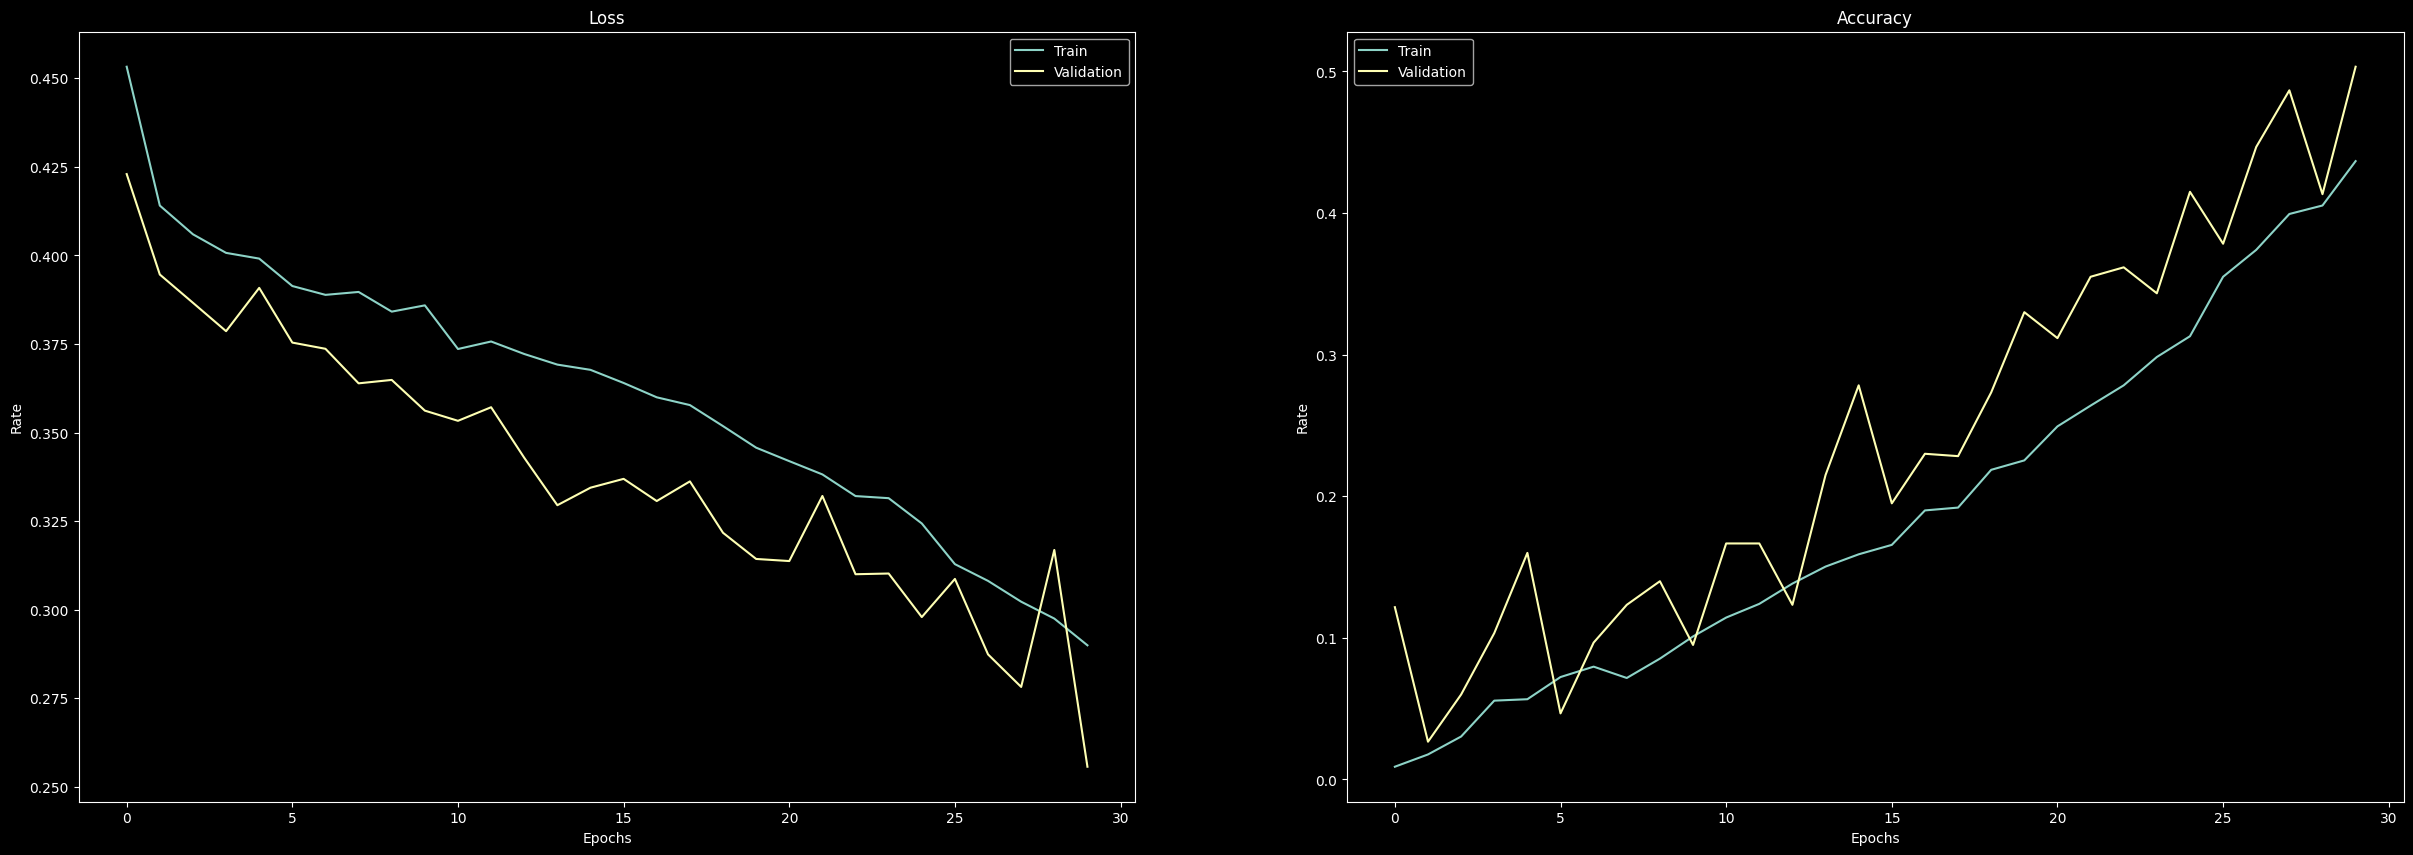

In [50]:
fig_path=f"/home/jack/Project/zdf/ComputerVision/plant_kaggle/Torch/resnext50_32x4d_num{train_num}_result.png"
plot_graphs(train_loss,val_loss,train_acc,val_acc,EPOCHS,fig_path)

## Test


In [51]:
gc.collect() 
torch.cuda.empty_cache()
test_data = Plant_Dataset(test_folder_path,test_path,test_df_cp, transforms=transforms,train=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False,num_workers=0)
images,predictions, acc = model_test(model,test_loader)
submission(images,predictions)
print("Model ResNet Train1 Test Acc:" ,acc)

Model ResNet Train1 Test Acc: 0.405


# 3rd Model

### Overview



*   **Architecture**: Resnext50 (Pre-Trained)  
*   **Optimizer**: AdamW
*   **Transforms**: Blur, HorizontalFlip, VerticalFlip, GaussNoise, IAASharpen, RandomBrightnessContrast, Normalize
*   **Batch Size**: 50
*   **Epochs** : 20
*   **Learning Rate**: 0.0001
*   **Learning Rate Scheduler**: None










## Model and Test settings

In [52]:
BS = 50
EPOCHS = 20
transforms = A.Compose([Blur(), HorizontalFlip(), VerticalFlip(), GaussNoise(),
                        IAASharpen(),RandomBrightnessContrast(),
                        A.Normalize(),ToTensorV2()])
val_transforms = A.Compose([A.Normalize(),ToTensorV2()])
train_num = 2

/home/jack/anaconda3/envs/plant_torch/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning:

IAASharpen is deprecated. Please use Sharpen instead



In [53]:
train_data = Plant_Dataset(train_folder_path,train_path,train_df_cp, transforms=transforms,train=True)
loader_train = DataLoader(train_data, batch_size=BS, shuffle=True,num_workers=4)
val_data = Plant_Dataset(val_folder_path,val_path, val_df_cp, transforms=val_transforms,train=True) 
loader_val = DataLoader(val_data,batch_size=BS, shuffle=False,num_workers=4)

In [54]:
model = models.resnext50_32x4d(pretrained=True)
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features,6)

/home/jack/anaconda3/envs/plant_torch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.

/home/jack/anaconda3/envs/plant_torch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /home/jack/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:13<00:00, 7.24MB/s]


In [55]:
model.cuda()
criterion = torch.nn.BCELoss()
criterion.cuda()
optimi = optim.AdamW(model.parameters(), lr=1e-4)
#scheduler = optim.lr_scheduler.StepLR(optimi, step_size=5,gamma=0.1)

In [56]:
model,train_loss,train_acc,val_loss,val_acc = train_val(model,loader_train,loader_val,optimi,criterion,EPOCHS)
model_path = f"/home/jack/Project/zdf/ComputerVision/plant_kaggle/Torch/pretrained/resnext50_32x4d_train_num{train_num}.pth"
save_model(model,optimi,EPOCHS,train_loss,val_loss,train_acc,val_acc, model_path)

Epoch 0, train_loss=0.2868 , acc=0.5503
Epoch 0, val_loss=0.1302 , acc=0.8233
Epoch 1, train_loss=0.1338 , acc= 0.8
Epoch 1, val_loss=0.1104 , acc=0.8067
Epoch 2, train_loss=0.101 , acc=0.8457
Epoch 2, val_loss=0.0976 , acc=0.8583
Epoch 3, train_loss=0.0914 , acc=0.8643
Epoch 3, val_loss=0.0866 , acc=0.8717
Epoch 4, train_loss=0.0718 , acc=0.888
Epoch 4, val_loss=0.0849 , acc=0.8733
Epoch 5, train_loss=0.058 , acc=0.912
Epoch 5, val_loss=0.0933 , acc=0.8767
Epoch 6, train_loss=0.0512 , acc=0.923
Epoch 6, val_loss=0.0993 , acc=0.8733
Epoch 7, train_loss=0.046 , acc=0.9363
Epoch 7, val_loss=0.1107 , acc=0.855
Epoch 8, train_loss=0.0375 , acc=0.95
Epoch 8, val_loss=0.1033 , acc=0.865
Epoch 9, train_loss=0.0348 , acc=0.9527
Epoch 9, val_loss=0.1016 , acc=0.8633
Epoch 10, train_loss=0.0296 , acc=0.9597
Epoch 10, val_loss=0.1084 , acc=0.88
Epoch 11, train_loss=0.0283 , acc=0.9623
Epoch 11, val_loss=0.121 , acc=0.8833
Epoch 12, train_loss=0.0278 , acc=0.9603
Epoch 12, val_loss=0.1166 , acc=0.

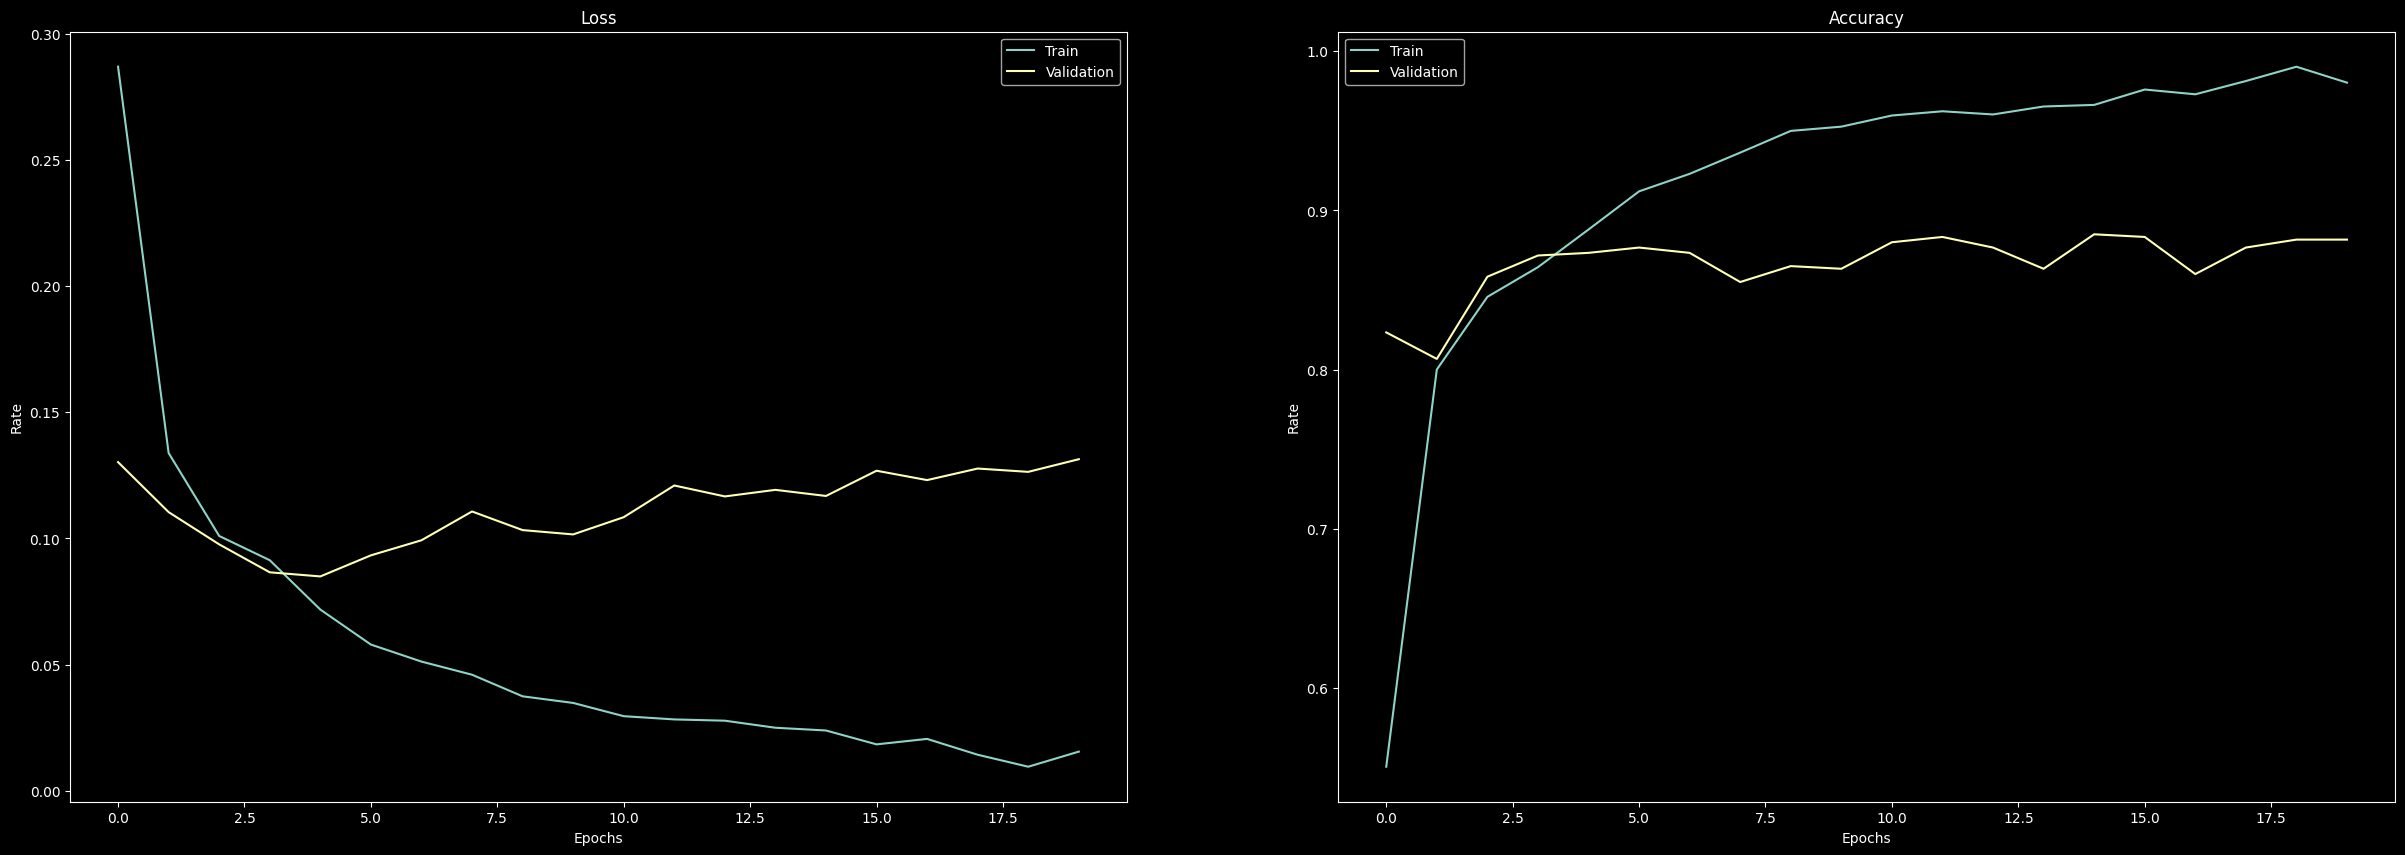

In [57]:
fig_path=f"/home/jack/Project/zdf/ComputerVision/plant_kaggle/Torch/resnext50_32x4d_num{train_num}_result.png"
plot_graphs(train_loss,val_loss,train_acc,val_acc,EPOCHS,fig_path)

## Test

In [58]:
gc.collect() 
torch.cuda.empty_cache()
test_data = Plant_Dataset(test_folder_path,test_path,test_df_cp, transforms=transforms,train=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False,num_workers=0)
images,predictions, acc = model_test(model,test_loader)
submission(images,predictions)
print("Model ResNet Train2 Test Acc:" ,acc)

Model ResNet Train2 Test Acc: 0.8466666666666667


# 4th Model

### Overview



*   **Architecture**: VGG19_BN (Pre-Trained)  
*   **Optimizer**: AdamW
*   **Transforms**: Blur,MotionBlur, HorizontalFlip, VerticalFlip, GaussNoise, IAASharpen, RandomBrightnessContrast, Normalize
*   **Batch Size**: 50
*   **Epochs** : 20
*   **Learning Rate**: 0.0001
*   **Learning Rate Scheduler**: None










## Model and Test settings

In [59]:
BS = 50
EPOCHS = 20
transforms = A.Compose([Blur(),MotionBlur(), HorizontalFlip(), VerticalFlip(), GaussNoise(),
                        IAASharpen(),RandomBrightnessContrast(),
                        A.Normalize(),ToTensorV2()])
val_transforms = A.Compose([A.Normalize(),ToTensorV2()])
train_num = 0

In [60]:
train_data = Plant_Dataset(train_folder_path,train_path,train_df_cp, transforms=transforms,train=True)
loader_train = DataLoader(train_data, batch_size=BS, shuffle=True,num_workers=4)
val_data = Plant_Dataset(val_folder_path,val_path, val_df_cp, transforms=val_transforms,train=True) 
loader_val = DataLoader(val_data,batch_size=BS, shuffle=False,num_workers=4)

In [61]:
model = models.vgg19_bn(pretrained=True)
model.classifier[6] = nn.Linear(4096,6)

/home/jack/anaconda3/envs/plant_torch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.



In [62]:
model.cuda()
criterion = torch.nn.BCELoss()
criterion.cuda()
optimi = optim.AdamW(model.parameters(), lr=1e-4)
#scheduler = optim.lr_scheduler.StepLR(optimi, step_size=5,gamma=0.1)

In [63]:
model,train_loss,train_acc,val_loss,val_acc = train_val(model,loader_train,loader_val,optimi,criterion,EPOCHS)
model_path = f"/home/jack/Project/zdf/ComputerVision/plant_kaggle/Torch/pretrained/vgg19_train_num{train_num}.pth"
save_model(model,optimi,EPOCHS,train_loss,val_loss,train_acc,val_acc, model_path)

Epoch 0, train_loss=0.2963 , acc=0.4047
Epoch 0, val_loss=0.1343 , acc=0.785
Epoch 1, train_loss=0.1586 , acc=0.7527
Epoch 1, val_loss=0.0983 , acc=0.8583
Epoch 2, train_loss=0.1209 , acc=0.803
Epoch 2, val_loss=0.0927 , acc=0.8683
Epoch 3, train_loss=0.1103 , acc=0.8273
Epoch 3, val_loss=0.0961 , acc=0.8683
Epoch 4, train_loss=0.1014 , acc=0.844
Epoch 4, val_loss=0.0979 , acc=0.8617
Epoch 5, train_loss=0.0882 , acc=0.8663
Epoch 5, val_loss=0.1045 , acc=0.8817
Epoch 6, train_loss=0.0742 , acc=0.8773
Epoch 6, val_loss=0.1071 , acc=0.8767
Epoch 7, train_loss=0.0755 , acc=0.8877
Epoch 7, val_loss=0.1113 , acc=0.8633
Epoch 8, train_loss=0.0728 , acc=0.89
Epoch 8, val_loss=0.0967 , acc=0.8883
Epoch 9, train_loss=0.0581 , acc=0.9113
Epoch 9, val_loss=0.1097 , acc=0.865
Epoch 10, train_loss=0.0682 , acc=0.9007
Epoch 10, val_loss=0.0989 , acc=0.8967
Epoch 11, train_loss=0.0614 , acc=0.9087
Epoch 11, val_loss=0.0993 , acc=0.8867
Epoch 12, train_loss=0.0447 , acc=0.9333
Epoch 12, val_loss=0.1125

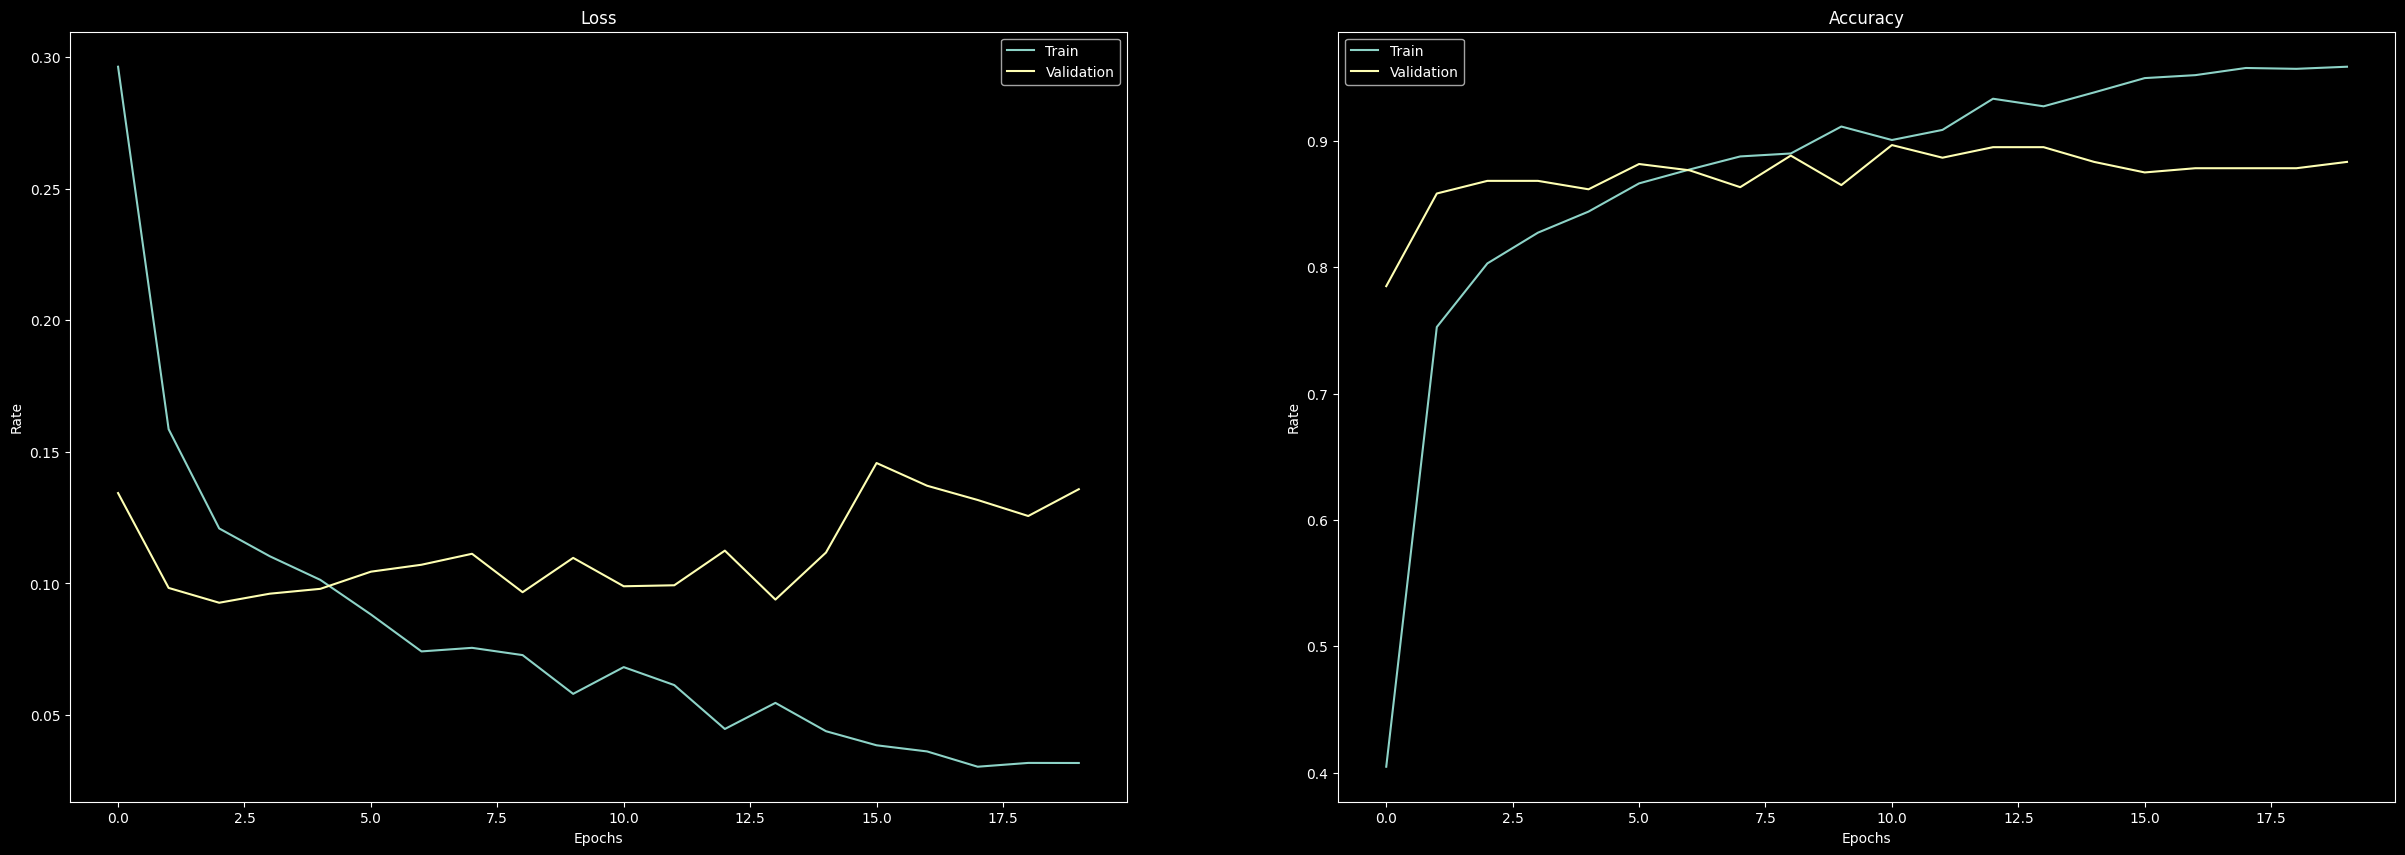

In [64]:
fig_path=f"/home/jack/Project/zdf/ComputerVision/plant_kaggle/Torch/vgg19_num{train_num}_result.png"
plot_graphs(train_loss,val_loss,train_acc,val_acc,EPOCHS,fig_path)

## Test

In [65]:
gc.collect() 
torch.cuda.empty_cache()
test_data = Plant_Dataset(test_folder_path,test_path,test_df_cp, transforms=transforms,train=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False,num_workers=0)
images,predictions, acc = model_test(model,test_loader)
submission(images,predictions)
print("Model Vgg19 Test Acc:" ,acc)

Model Vgg19 Test Acc: 0.8383333333333334


# 5th Model


### Overview



*   **Architecture**: VGG19_BN (Pre-Trained)  
*   **Optimizer**: AdamW
*   **Transforms**: Blur,MotionBlur, HorizontalFlip, VerticalFlip, GaussNoise, IAASharpen, RandomBrightnessContrast, Normalize
*   **Batch Size**: 50
*   **Epochs** : 20
*   **Learning Rate**: 0.0001
*   **Learning Rate Scheduler**: None










## Model and Test settings

In [103]:
BS = 64
EPOCHS = 40
train_num = 0
transforms = A.Compose([Blur(),MotionBlur(), HorizontalFlip(), VerticalFlip(), GaussNoise(),
                        IAASharpen(),RandomBrightnessContrast(),
                        A.Normalize(),ToTensorV2()])
val_transforms = A.Compose([A.Normalize(),ToTensorV2()])

In [104]:
train_data = Plant_Dataset(train_folder_path,train_path, train_df_cp, transforms=transforms,train=True)
loader_train = DataLoader(train_data, batch_size=BS, shuffle=True,num_workers=4)
val_data = Plant_Dataset(val_folder_path,val_path, val_df_cp, transforms=transforms,train=True) 
loader_val = DataLoader(val_data,batch_size=BS, shuffle=False,num_workers=4)

In [105]:
model = models.swin_b(weights=models.Swin_B_Weights.IMAGENET1K_V1)
model.head = nn.Linear(1024, 6)
#model = load_model("/home/jack/Project/zdf/ComputerVision/plant_kaggle/Torch/pretrained/swin_b_train_num0.pth", model, optimi)
#model.train()
model.cuda()
criterion = torch.nn.BCELoss()
criterion.cuda()
optimi = optim.AdamW(model.parameters(), lr=1e-4)

In [106]:
model,train_loss,train_acc,val_loss,val_acc = train_val(model,loader_train,loader_val,optimi,criterion,EPOCHS)

model_path = f"/home/jack/Project/zdf/ComputerVision/plant_kaggle/Torch/pretrained/swin_b_train_num{train_num}.pth"
save_model(model, optimi, EPOCHS, train_loss, val_loss, train_acc, val_acc, model_path)

Epoch 0, train_loss=0.3372 , acc=0.2703
Epoch 0, val_loss=0.171 , acc=0.7733
Epoch 1, train_loss=0.1703 , acc=0.7317
Epoch 1, val_loss=0.1326 , acc=0.815
Epoch 2, train_loss=0.1382 , acc=0.7837
Epoch 2, val_loss=0.1117 , acc=0.8233
Epoch 3, train_loss=0.1198 , acc=0.813
Epoch 3, val_loss=0.1112 , acc=0.845
Epoch 4, train_loss=0.1093 , acc=0.8247
Epoch 4, val_loss=0.1028 , acc=0.8683
Epoch 5, train_loss=0.1002 , acc=0.851
Epoch 5, val_loss=0.1011 , acc=0.8567
Epoch 6, train_loss=0.0941 , acc=0.8563
Epoch 6, val_loss=0.1149 , acc=0.8417
Epoch 7, train_loss=0.0888 , acc=0.8637
Epoch 7, val_loss=0.1069 , acc=0.865
Epoch 8, train_loss=0.0771 , acc=0.876
Epoch 8, val_loss=0.1049 , acc=0.8783
Epoch 9, train_loss=0.0717 , acc=0.8923
Epoch 9, val_loss=0.1207 , acc=0.865
Epoch 10, train_loss=0.0696 , acc=0.894
Epoch 10, val_loss=0.0951 , acc=0.885
Epoch 11, train_loss=0.0698 , acc=0.8937
Epoch 11, val_loss=0.1092 , acc=0.8717
Epoch 12, train_loss=0.0672 , acc=0.8957
Epoch 12, val_loss=0.0963 , a

### Load the Model and Continue Training

In [107]:
# load_model("/home/jack/Project/zdf/ComputerVision/plant_kaggle/Torch/pretrained/swin_b_train_num0.pth", model, optimi)
# model.train()
# model.cuda()
# criterion = torch.nn.BCELoss()
# criterion.cuda()
# optimi = optim.AdamW(model.parameters(), lr=1e-4)
# model,train_loss,train_acc,val_loss,val_acc = train_val(model,loader_train,loader_val,optimi,criterion,EPOCHS)

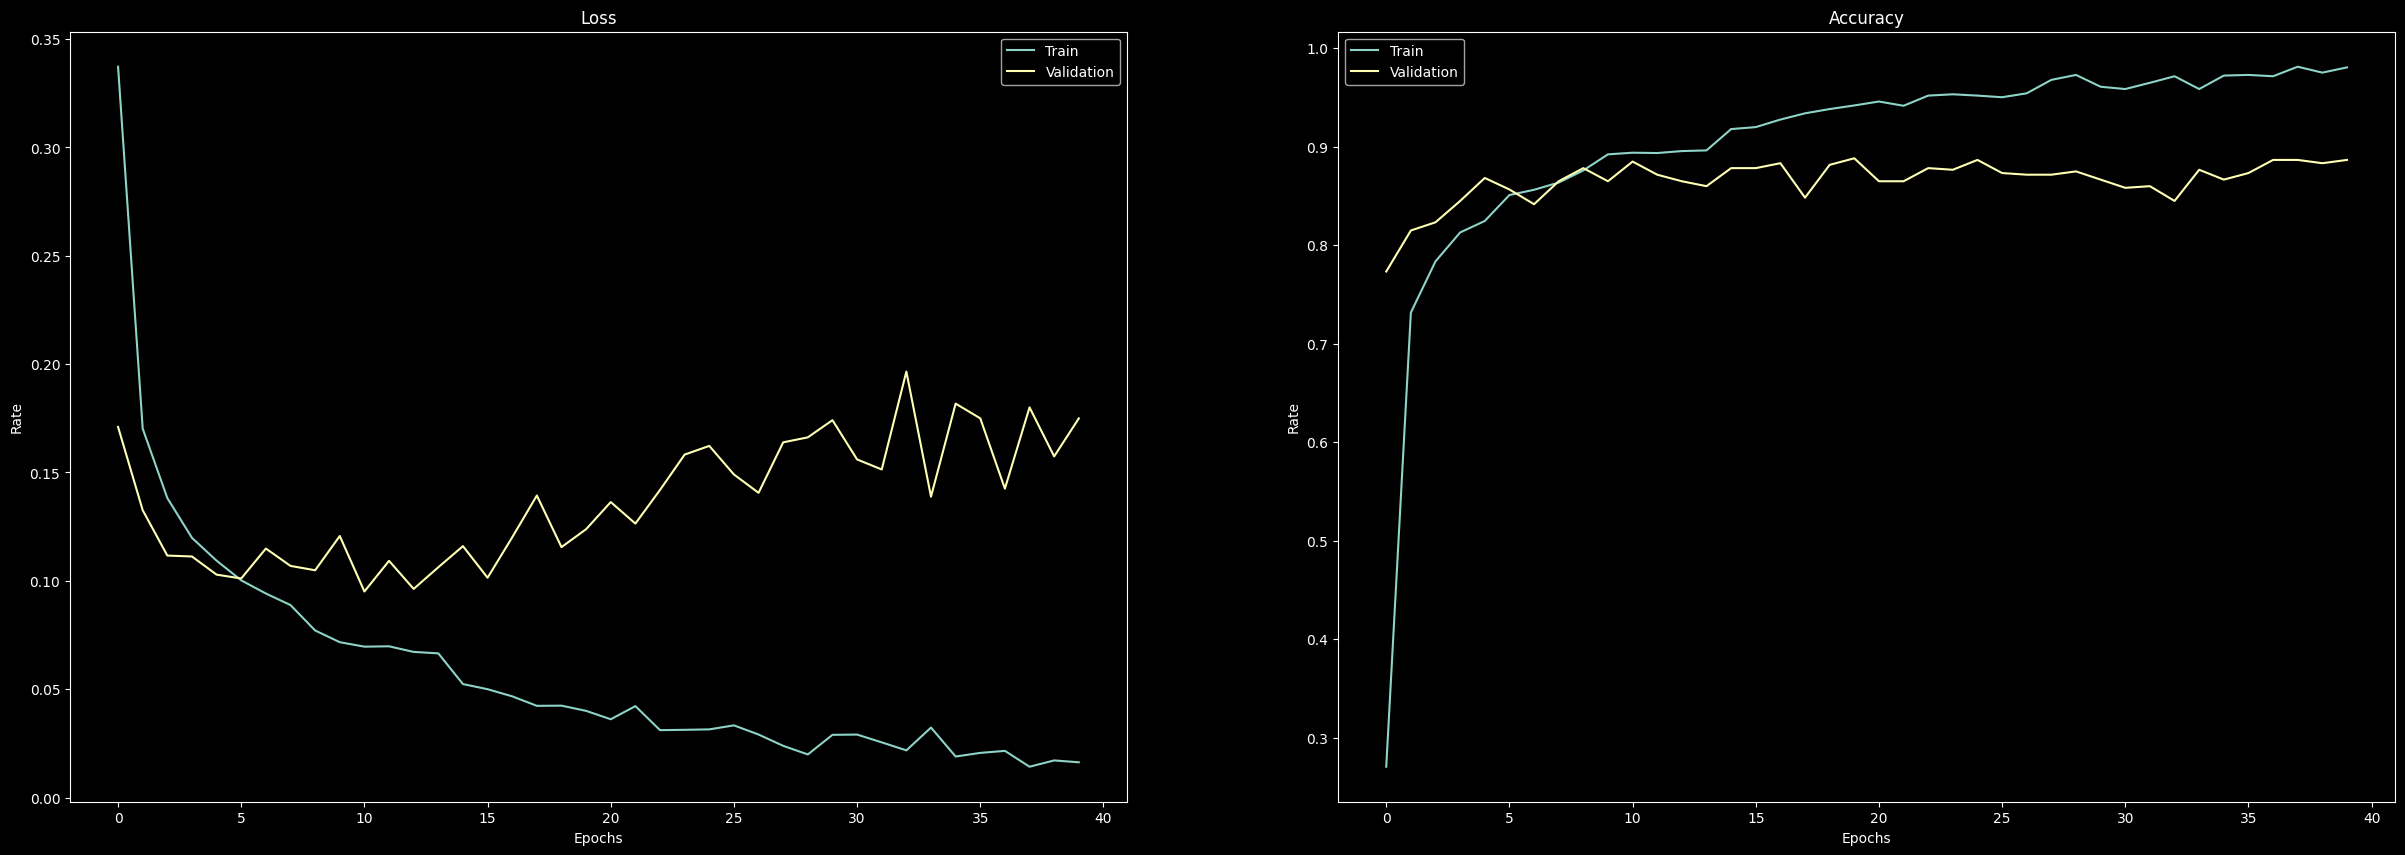

In [108]:
fig_path=f"/home/jack/Project/zdf/ComputerVision/plant_kaggle/Torch/swin_b_num{train_num}_result.png"
plot_graphs(train_loss,val_loss,train_acc,val_acc,EPOCHS, fig_path)

## Test

In [109]:
gc.collect() 
torch.cuda.empty_cache()
test_data = Plant_Dataset(test_folder_path,test_path,test_df_cp, transforms=transforms,train=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False,num_workers=0)
images,predictions, acc = model_test(model,test_loader)
submission(images,predictions)
print("Model Swin_b Test Acc:" ,acc)

Model Swin_b Test Acc: 0.8716666666666667
